### The original implementation has lacking saving and loading functions. Somehow, it saves the generator and the discriminator but not the optimizer. Also, the load function only loads the generator, when it should load the discriminator too. 

In [3]:
import os
if os.getcwd().endswith('notebooks'): os.chdir('..')
    
from random import randint, shuffle
from random import random as rand

import numpy as np
import torch
import torch.nn as nn
import argparse
from tensorboardX import SummaryWriter
import os
import multiprocessing as mp
import src.tokenization
import src.models
import src.optim
import src.train
from src.utils import set_seeds, get_device
from torch.utils.data import Dataset, DataLoader
from src.data import seek_random_offset, SentPairDataset, Pipeline, Preprocess4Pretrain, seq_collate

from config import CONFIG as args

cfg = src.train.Config.from_json(args.train_cfg)
model_cfg = src.models.Config.from_json(args.model_cfg)

tokenizer = src.tokenization.FullTokenizer(vocab_file=args.vocab, do_lower_case=True)
tokenize = lambda x: tokenizer.tokenize(tokenizer.convert_to_unicode(x))

pipeline = [Preprocess4Pretrain(args.max_pred,
                                args.mask_prob,
                                list(tokenizer.vocab.keys()),
                                tokenizer.convert_tokens_to_ids,
                                model_cfg.max_len,
                                args.mask_alpha,
                                args.mask_beta,
                                args.max_gram)]
data_iter = DataLoader(SentPairDataset(args.data_file,
                            cfg.batch_size,
                            tokenize,
                            model_cfg.max_len,
                            pipeline=pipeline), 
                        batch_size=cfg.batch_size, 
                        collate_fn=seq_collate,
                        num_workers=mp.cpu_count())

from src.pretrain import Discriminator
discriminator = Discriminator(model_cfg)

from src.pretrain import Generator
generator_cfg = src.models.Config.from_json(args.generator_cfg)
generator = Generator(generator_cfg)

optimizer = src.optim.optim4GPU(cfg, generator, discriminator)
# self.g_optimizer = optim.optim4GPU(cfg, generator)
trainer = src.train.AdversarialTrainer(cfg, 
    discriminator, generator, 
    data_iter, 
    optimizer, args.ratio, args.save_dir, get_device())
os.makedirs(os.path.join(args.log_dir, args.name), exist_ok=True)
writer = SummaryWriter(log_dir=os.path.join(args.log_dir, args.name)) # for tensorboardX

# trainer.train(writer, model_file=None, data_parallel=False)

cuda (1 GPUs)


### Check saved files

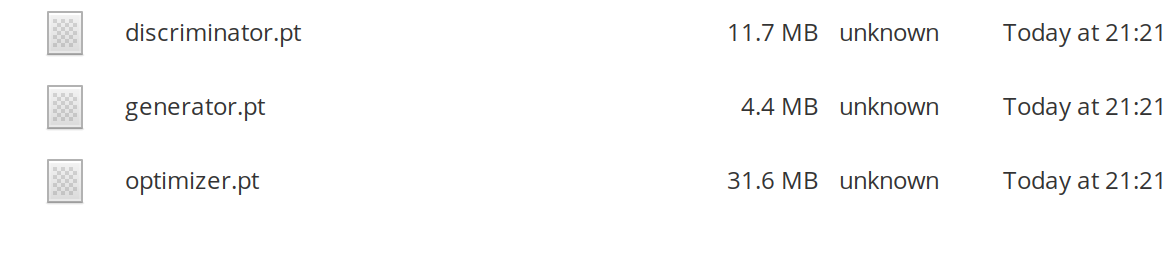

### Check model params currently in memory

In [2]:
trainer.discriminator.load_state_dict

NameError: name 'trainer' is not defined

### Check model params loaded from path

In [10]:
# trainer.load(path='saved')
# trainer.optimizer.state_dict()

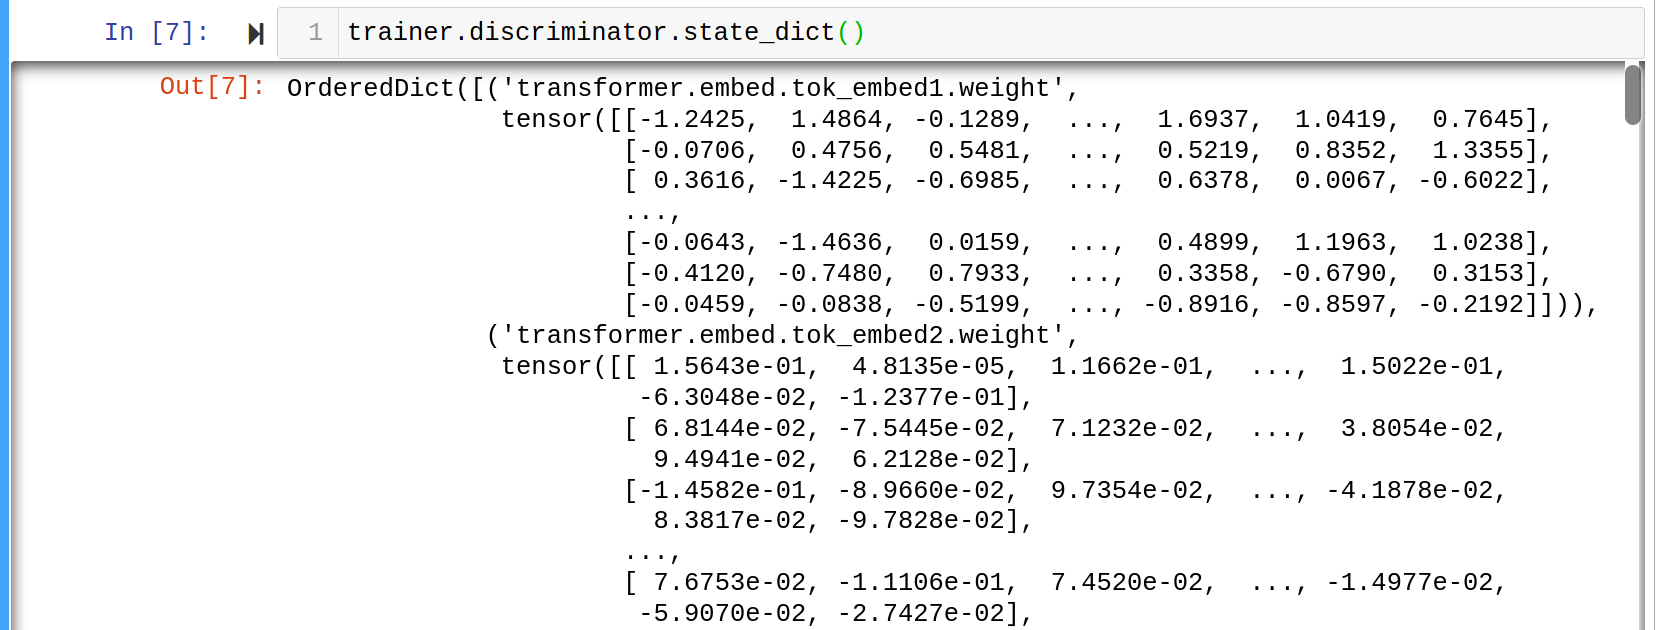

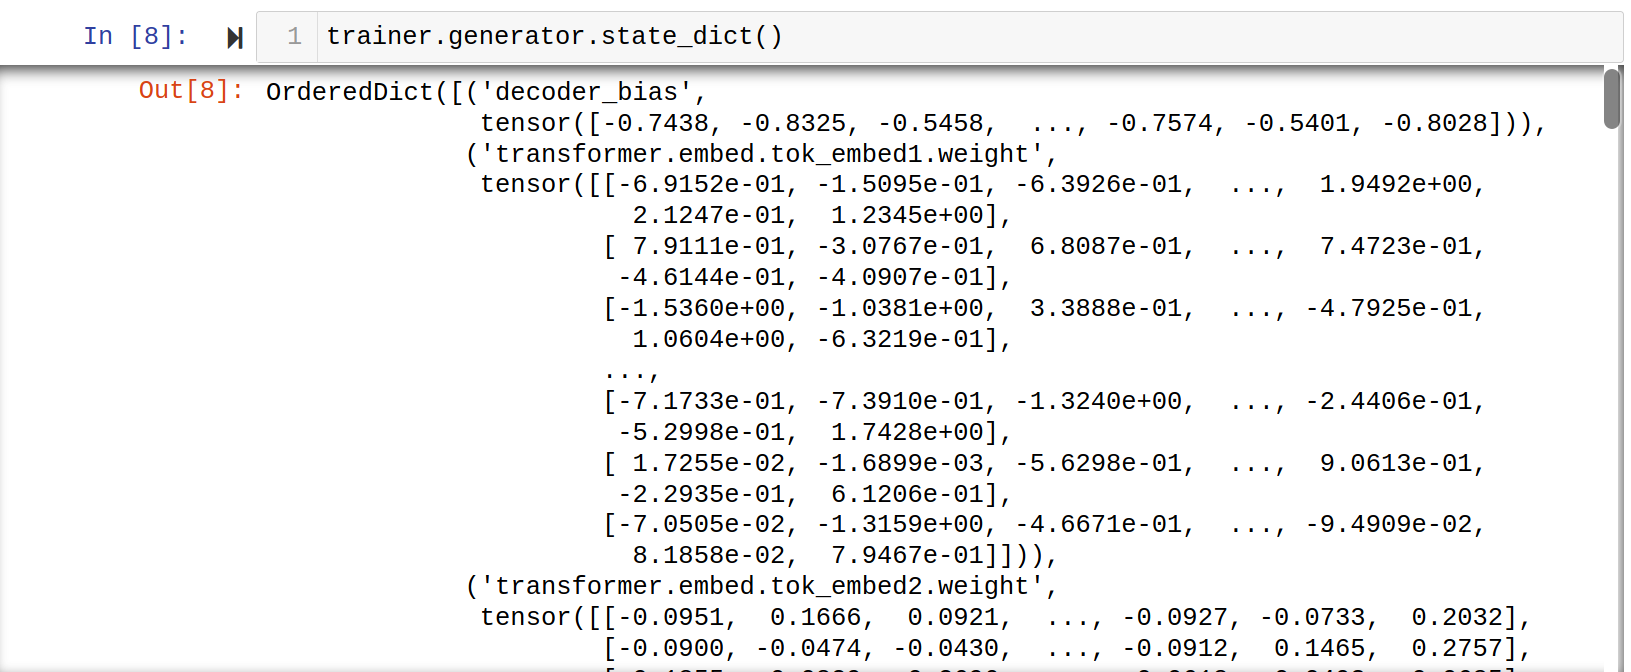

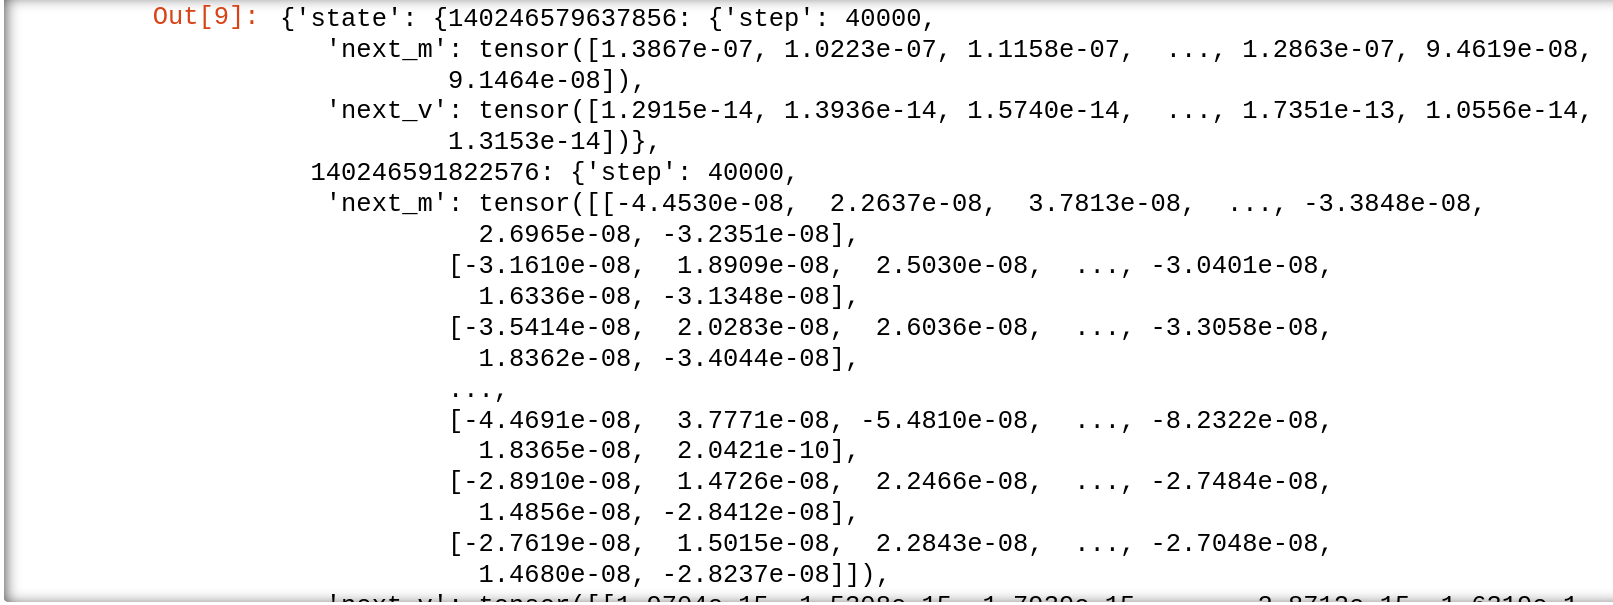